In [ ]:
# LSTM (.809, .821)
from itertools import product

# For methos A experiments
dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[200],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.7,0.8],                      
          'dense_dropout':[0.5,0.7]}

arch_params_combos  = list(product( *arch_params.values() )) 
arch_params_keys = arch_params.keys()        


In [ ]:
# CNN (.816, .822)
from itertools import combinations
from itertools import product

dense_layers_s = [(400,75),
                      (200,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,200],
              'conv_layers_activation':['tanh','relu'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3,0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))

# Ajustes iniciales

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%ls

'BEFORE JUNE'/                        FULL_DATASET_CLASSIFIERS.ipynb
'CNN EXPERIMENTS (TR).ipynb'         'LSTM_EXPERIMENTS_(HTA) (2).ipynb'
'ConvLSTM_EXPERIMENTS_(AG).ipynb'    'NN_EXPERIMENTS_(TR).ipynb'
'Copy_of_NN_EXPERIMENTS_(HS).ipynb'   OTROS/
 CRIPTOGRAFIA/                       'PT-II VARIOS'/
 dataset_files/


In [3]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar los módulos *_utils

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [ ]:
import pickle

# Funciones locales

## Prototipos de modelo

The requirements to use the cuDNN implementation are:

1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. Inputs, if use masking, are strictly right-padded.
7. Eager execution is enabled in the outermost context.

Check: KERAS docs [https://keras.io/api/layers/recurrent_layers/lstm/]



### RecurrentLSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def recurrentLSTM_NetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  units_lstm = params['units_lstm']
  merge_mode = params['merge_mode']

  n_filters  = params['n_filters']
  kernel_size_1, kernel_size_2, kernel_size_3 = params['kernels_sizes']
  conv_activation = params['conv_activation'] 
  units_DL1, units_DL2 = params['dense_layers_sizes']

  lstm_dropout  = params['lstm_dropout']
  spatial_dropout = params['spatial_dropout']
  dense_dropout = params['dense_dropout']

  embedding_sequence_input = keras.Input(name='INPUT',
                                          shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), 
                                          dtype="float64")
  
  LSTM_layer    = layers.LSTM(units=units_lstm, dropout=lstm_dropout, recurrent_dropout=0, return_sequences=True, name='LSTM')
  BiLSTM_layer  = layers.Bidirectional(LSTM_layer, merge_mode, name='BI-LSTM')

  lstm_out = BiLSTM_layer(embedding_sequence_input)

  cnn_1 = layers.Conv1D(n_filters, kernel_size_1, activation=conv_activation, name = 'CNN_1')(lstm_out)
  cnn_1 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_1')(cnn_1)

  cnn_2 = layers.Conv1D(n_filters, kernel_size_2, activation=conv_activation, name = 'CNN_2')(lstm_out)
  cnn_2 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_2')(cnn_2)

  cnn_3 = layers.Conv1D(n_filters, kernel_size_3, activation=conv_activation, name = 'CNN_3')(lstm_out)
  cnn_3 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_3')(cnn_3)


  if params['pooling_method'] == 'max':
    pool_1 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_1')(cnn_1)
    pool_2 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_2')(cnn_2)
    pool_3 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_3')(cnn_3)
  elif params['pooling_method'] == 'average':
    pool_1 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_1')(cnn_1)
    pool_2 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_2')(cnn_2)
    pool_3 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_3')(cnn_3)

  fcnn_input = layers.Concatenate(axis=1, name = 'CONCATENATE')([pool_1, pool_2, pool_3])
  fc_layer_1 = layers.Dense(units_DL1, activation="relu", name = 'DL_1')(fcnn_input)
  fc_layer_1 = layers.Dropout(dense_dropout, name = 'DROP_1')(fc_layer_1)
  fc_layer_2 = layers.Dense(units_DL2, activation="relu", name = 'DL_2')(fc_layer_1)
  fc_layer_2 = layers.Dropout(dense_dropout, name = 'DROP_2')(fc_layer_2)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fc_layer_2)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fc_layer_2)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


# Búsqueda número 1 (optimizers)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[200],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3),(2,3,4)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          bidirectionalLSTM_NetModel, 
                          search_space[:25],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLST/HS/experiments_1.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/ConvLSTM/HS/experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(48, 21)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

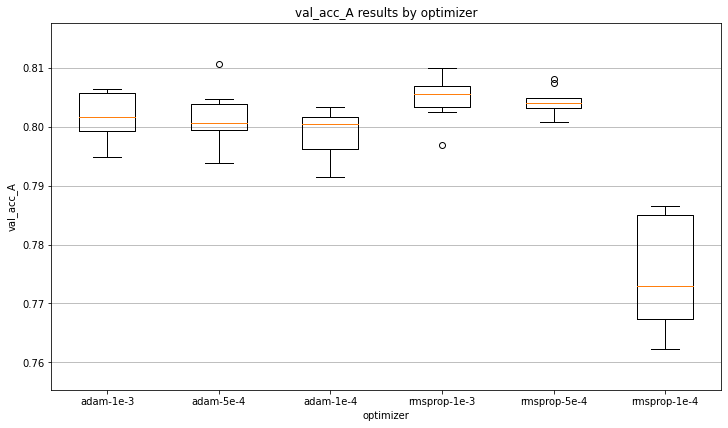

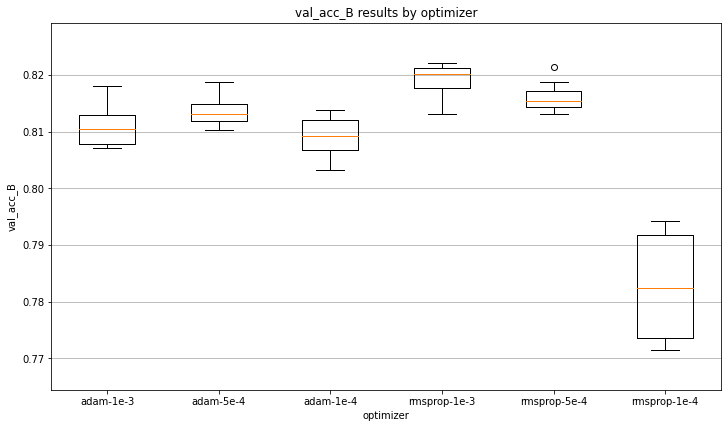

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

### Resumen de los resultados (checked)

* optimizador: ['adam-5e-4', **'rmsprop-1e-3'**]

# Búsqueda número 2 (**lstm_units**, kernels_sizes, batch_size)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[150,200,250],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3),(2,3,4)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4','rmsprop-1e-3'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          recurrentLSTM_NetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLSTM/HS/experiments_2.df',
                          backup_freq=3,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
results_list = ['./Results/LSTM/ConvLSTM_HS_experiments_2_batch_1.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_2.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_3.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_4.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_5.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_6.df',
                './Results/LSTM/ConvLSTM_HS_experiments_2_batch_7.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/LSTM/ConvLSTM_HS_experiments_2.df')

In [ ]:
import pickle
with open('./Results/ConvLSTM/HS/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(48, 21)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(5)

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

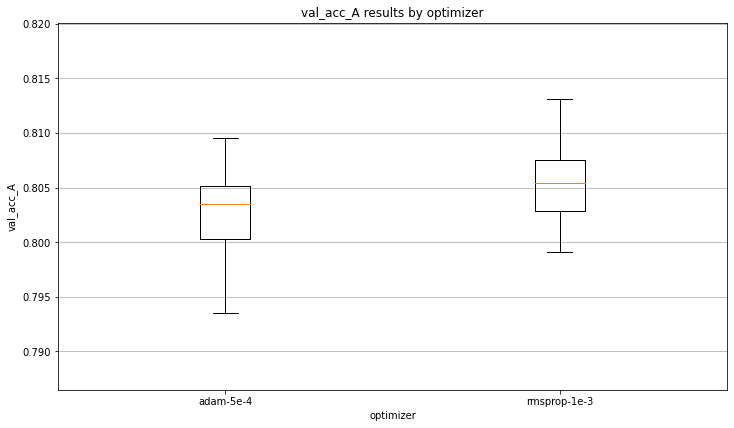

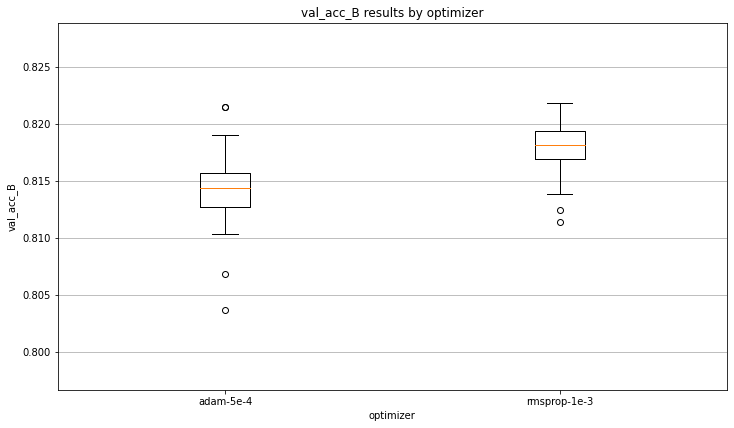

In [ ]:
params_dict = {'optimizer':['adam-5e-4','rmsprop-1e-3']}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

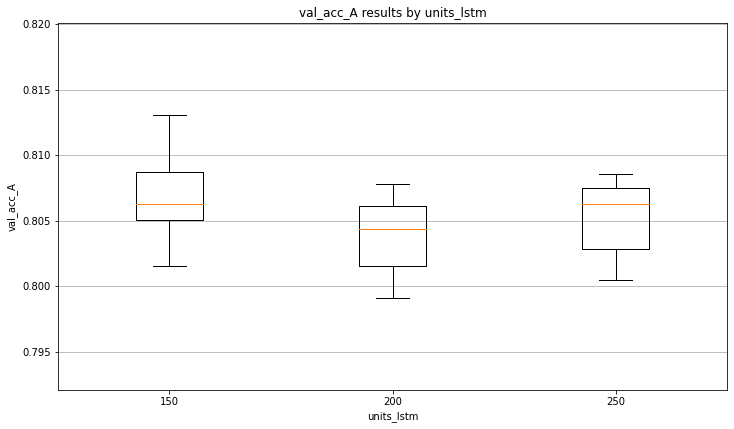

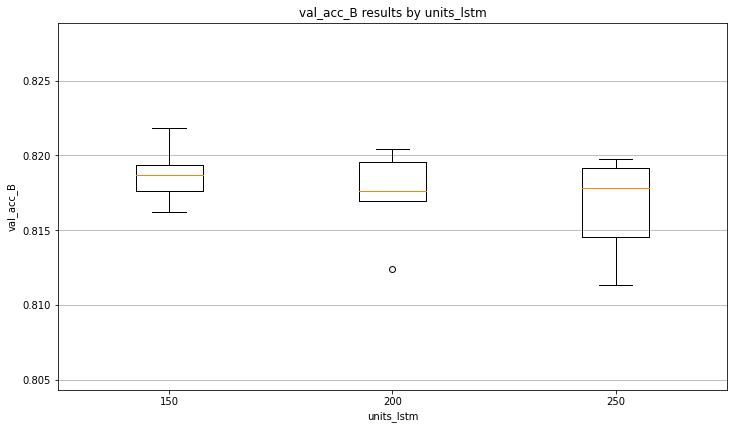

In [ ]:
optimizer_mask = results_df.optimizer=='rmsprop-1e-3'

params_dict = {'units_lstm':[150,200,250]}

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')

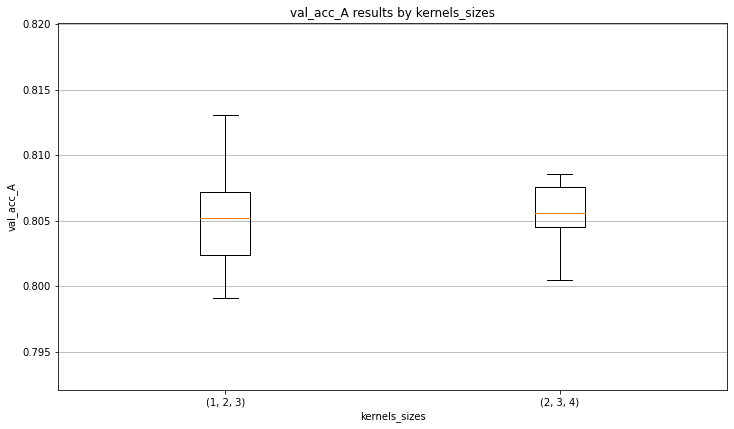

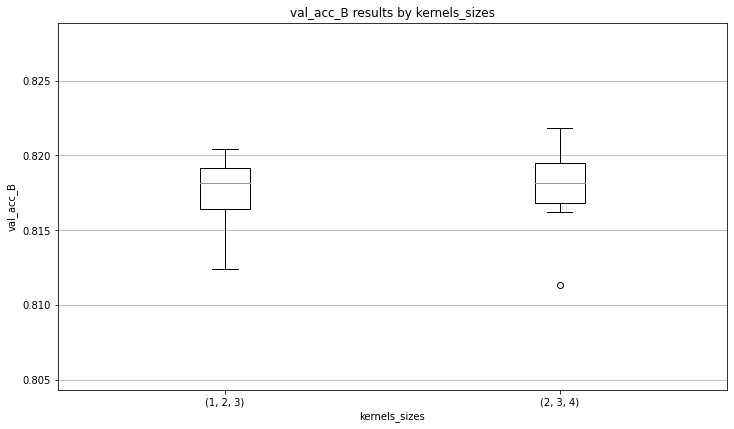

In [ ]:
params_dict = {'kernels_sizes':[(1,2,3),(2,3,4)]}

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['kernels_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['kernels_sizes'],
                       metric='val_acc_B')

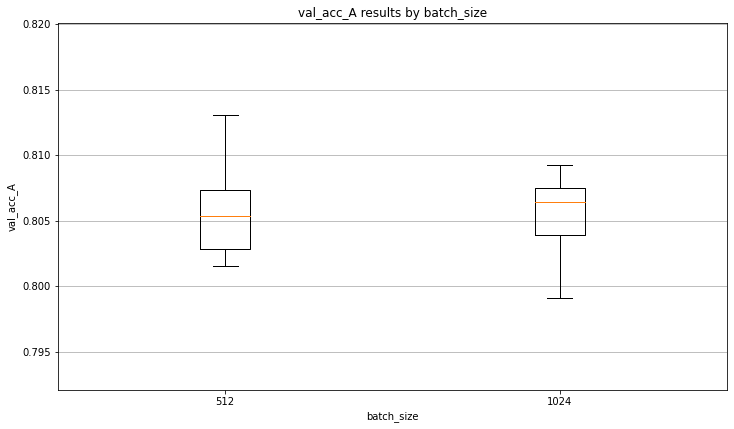

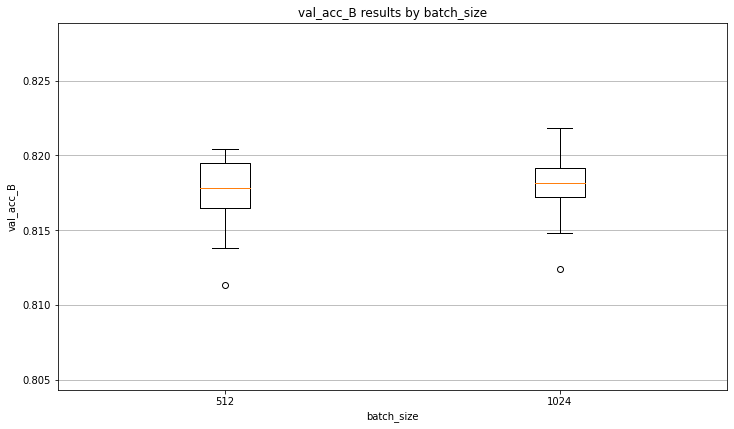

In [ ]:
params_dict = {'batch_size':[512,1024]}

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* LSTM-units: 150
* kernels_sizes: [(1,2,3), -(2,3,4)-]

* batch_size: [512, -1024-]
* optimizador: [ **'rmsprop-1e-3'**]

# Búsqueda número 3 (n_filters, cnn_activ)


## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[150],
          'merge_mode':['concat'],
          'n_filters':[100,150,200],
          'kernels_sizes':[(1,2,3)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh','relu'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4','rmsprop-1e-3'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          bidirectionalLSTM_NetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/LSTM/BiLSTM/HS_experiments_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
results_list = ['./Results/LSTM/ConvLSTM_HS_experiments_3_batch_1.df',
                './Results/LSTM/ConvLSTM_HS_experiments_3_batch_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/LSTM/ConvLSTM_HS_experiments_3.df')

In [ ]:
import pickle
with open('./Results/LSTM/ConvLSTM_HS_experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(48, 21)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,units_lstm,dense_layers_sizes,merge_mode,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
33,MnBRzwZS,200,"(200, 100)",concat,0.7,0.5,adam-1e-3,1024,75,43,0.821676,0.807839,26,50,0.784810,0.816588
16,FzTpMsAn,200,"(300, 100)",concat,0.7,0.7,adam-1e-3,512,75,25,0.788660,0.806792,16,32,0.794028,0.817289
14,vASZSGcG,200,"(300, 100)",concat,0.7,0.5,adam-1e-3,512,75,24,0.793443,0.806097,24,33,0.813801,0.812745
17,JhMPsRLG,200,"(300, 100)",concat,0.7,0.7,adam-1e-3,1024,75,31,0.770751,0.803989,27,64,0.796182,0.816937
35,tMFCBnpj,200,"(200, 100)",concat,0.7,0.7,adam-1e-3,1024,75,39,0.789535,0.803296,29,58,0.795075,0.812393


In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,units_lstm,merge_mode,n_filters,kernels_sizes,dense_layers_sizes,conv_activation,pooling_method,spatial_dropout,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
18,IxnESFiJ,150,concat,150,"(1, 2, 3)","(200, 100)",tanh,max,0.5,0.5,0.3,rmsprop-1e-3,1024,75,35,0.736802,0.804692,41,68,0.755469,0.827792
3,MjOxgnpS,150,concat,150,"(1, 2, 3)","(300, 100)",tanh,max,0.3,0.5,0.3,rmsprop-1e-3,1024,75,45,0.768009,0.805038,34,69,0.795779,0.825341
15,pVPTGKCC,150,concat,150,"(1, 2, 3)","(200, 100)",tanh,max,0.3,0.5,0.3,rmsprop-1e-3,1024,75,63,0.802544,0.805735,35,58,0.787611,0.824642
17,qhVPVpDO,150,concat,150,"(1, 2, 3)","(200, 100)",tanh,max,0.3,0.7,0.3,rmsprop-1e-3,1024,75,65,0.750394,0.808190,58,72,0.749868,0.824287
7,sfNUtKPd,150,concat,150,"(1, 2, 3)","(300, 100)",tanh,max,0.5,0.7,0.3,adam-5e-4,1024,75,26,0.740594,0.808190,26,52,0.768537,0.822540


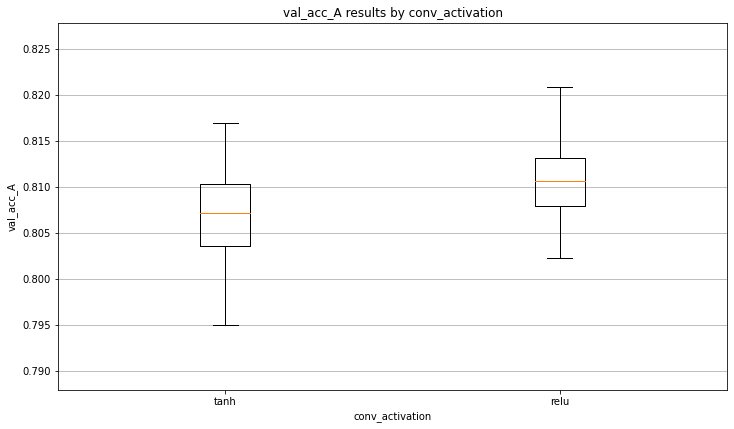

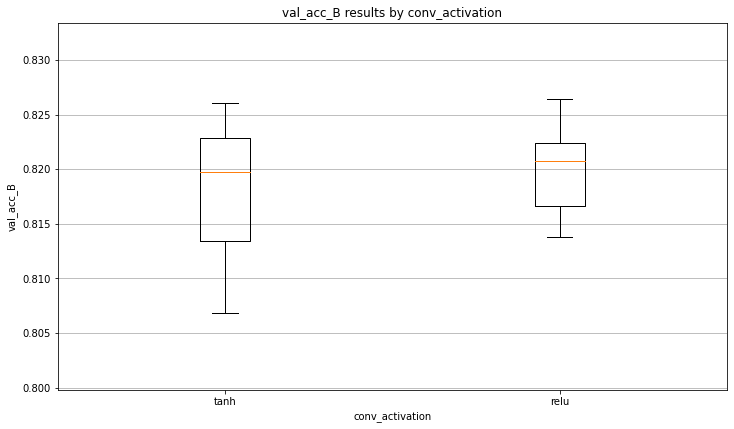

In [ ]:
params_dict = {'conv_activation':['tanh','relu']}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['conv_activation'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['conv_activation'],
                       metric='val_acc_B')

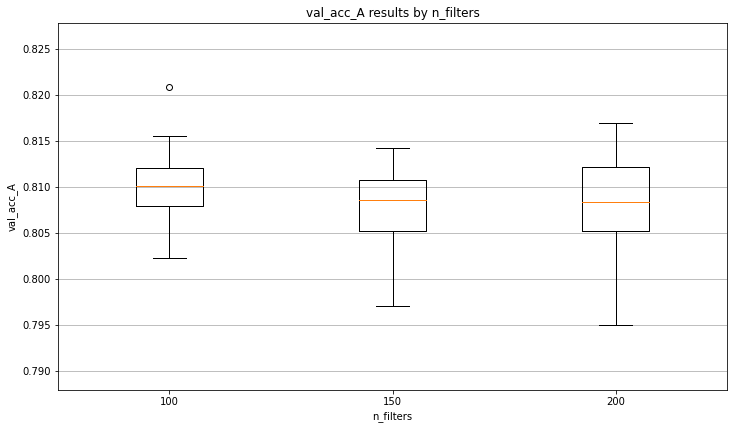

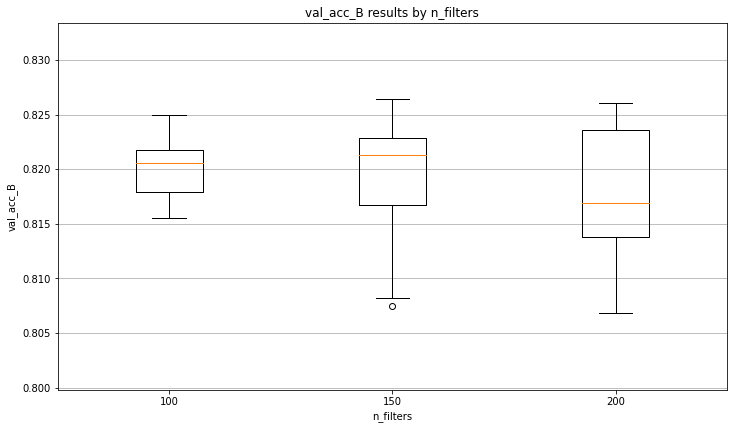

In [ ]:
params_dict = {'n_filters':[100,150,200]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* LSTM-units: 150, 200
* kernels_sizes: [**(1,2,3)**, (2,3,4)]
* n_filters: [150, **200**]
* conv_activ: ['relu']



* batch_size: [512, **1024**]
* optimizador: ['adam-5e-4', 'rmsprop-1e-3']

# Búsqueda número 4 (dropout)

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[200],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['relu'],
          'pooling_method':['max'],
          'spatial_dropout':[0.3,0.5,0.7],
          'lstm_dropout':[0.3,0.5,0.7],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

18 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4','rmsprop-1e-3'],
                       'batch_size':[1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


36 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          recurrentLSTM_NetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/LSTM/ConvLSTM_HS_experiments_4.df',
                          backup_freq=3,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
results_list = ['./Results/LSTM/ConvLSTM_HS_experiments_4_batch_1.df',
                './Results/LSTM/ConvLSTM_HS_experiments_4_batch_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/LSTM/ConvLSTM_HS_experiments_4.df')

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/LSTM/ConvLSTM_HS_experiments_4.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(36, 21)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,units_lstm,merge_mode,n_filters,kernels_sizes,dense_layers_sizes,conv_activation,pooling_method,spatial_dropout,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
4,bXHndrxG,200,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.3,0.7,0.3,adam-5e-4,1024,75,39,0.787727,0.816240,28,55,0.798810,0.823241
2,QmUhyLEV,200,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.3,0.5,0.3,adam-5e-4,1024,75,22,0.794084,0.813090,19,35,0.798983,0.820443
10,FmZKPmRv,200,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.5,0.7,0.3,adam-5e-4,1024,75,50,0.803768,0.813086,31,66,0.790819,0.824641
16,XZXnHwcj,200,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.7,0.7,0.3,adam-5e-4,1024,75,49,0.776351,0.811340,25,49,0.760485,0.823240
28,jQvACHkF,200,concat,150,"(1, 2, 3)","(200, 100)",relu,max,0.5,0.7,0.3,adam-5e-4,1024,75,43,0.781893,0.810638,31,59,0.787201,0.819041


In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head(36)

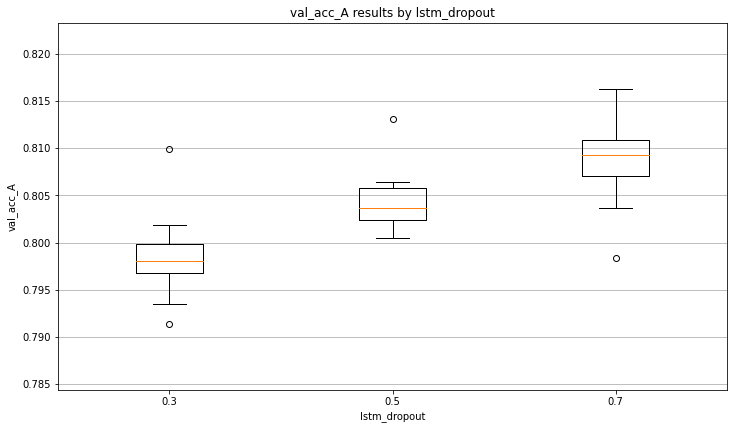

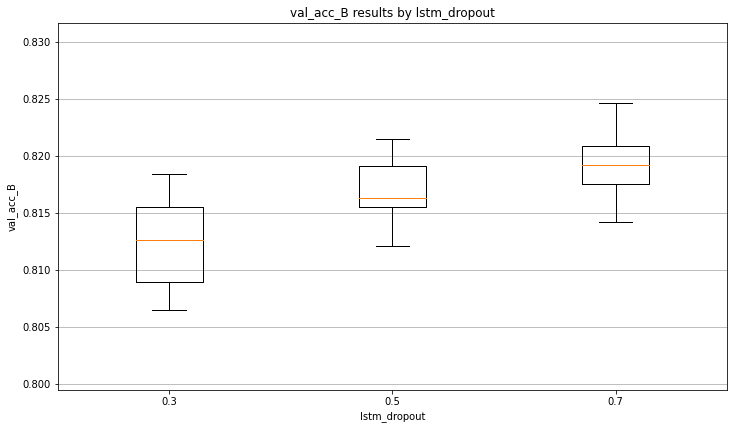

In [ ]:
params_dict = {'lstm_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_B')

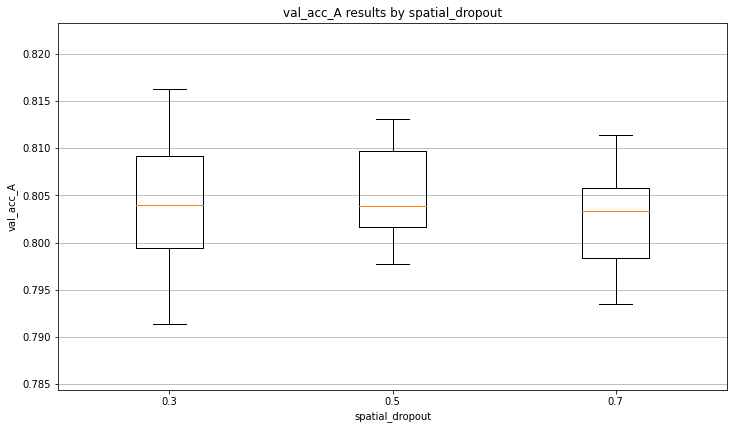

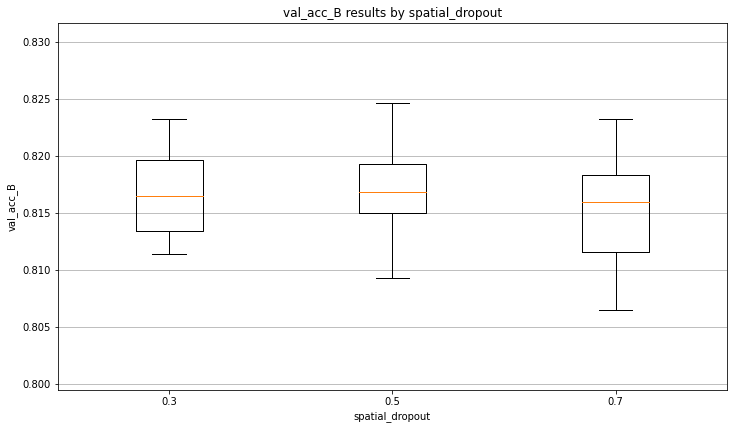

In [ ]:
params_dict = {'spatial_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_B')

### Resumen de los resultados

* LSTM-units: 150, 200
* kernels_sizes: [**(1,2,3)**, (2,3,4)]
* n_filters: [150, **200**]
* conv_activ: ['relu']
* lstm_dropout: [0.7]
* spatial_dropout: [0.5]
* dense_dropout: [0.3]



* batch_size: [512, **1024**]
* optimizador: ['adam-5e-4', 'rmsprop-1e-3']

# Búsqueda número 5 (FINAL)

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[150, 200],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['relu'],
          'pooling_method':['max'],
          'spatial_dropout':[0.7],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4','rmsprop-1e-3'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


36 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          recurrentLSTM_NetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/LSTM/ConvLSTM_HS_experiments_5f.df',
                          backup_freq=3,
                          save_history_files=True,
                          save_models_as_json=False,
                          save_weights=True
                          )

## Resultados

In [ ]:
results_list = ['./Results/LSTM/ConvLSTM_HS_experiments_5f_batch_2.df',
                './Results/LSTM/ConvLSTM_HS_experiments_5f_batch_2-2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/LSTM/ConvLSTM_HS_experiments_5f.df')   

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/LSTM/ConvLSTM_HS_experiments_5f.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(15, 22)

In [ ]:
results_df.head(3)

,conf_ID,units_lstm,merge_mode,n_filters,kernels_sizes,dense_layers_sizes,conv_activation,pooling_method,spatial_dropout,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
0,MvOlAtXJ,150,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.7,0.5,0.3,adam-5e-4,512,75,19,0.773765,0.807005,19,68,20,0.810633,0.822797
1,QOTsRhWU,150,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.7,0.5,0.3,adam-5e-4,1024,75,28,0.779967,0.806197,22,63,34,0.807136,0.821995
2,SgzKWUEe,150,concat,150,"(1, 2, 3)","(300, 100)",relu,max,0.7,0.5,0.3,rmsprop-1e-3,512,75,40,0.783966,0.807006,35,54,40,0.788300,0.820198


In [ ]:
# prepare the permanent directory 
import os
import shutil

for config_ID in results_df['conf_ID']:

  saved_weights_dir = f'./trained_models/{config_ID}' 
  json_file_path = f'./models_json_files/{config_ID}.json'

  history_dict_path = f'./history_files/{config_ID}.dict'

  if os.path.exists(saved_weights_dir):
    print('deleting saved weights')
    shutil.rmtree(saved_weights_dir)

  if os.path.exists(json_file_path):
    print('deleting', json_file_path)
    os.remove(json_file_path)

  if os.path.exists(history_dict_path):
    print('deleting', history_dict_path)
    os.remove(history_dict_path)

deleting saved weights
deleting ./models_json_files/GQquLvWa.json
deleting ./history_files/GQquLvWa.dict
deleting saved weights
deleting ./models_json_files/WYOYgJuB.json
deleting ./history_files/WYOYgJuB.dict
deleting saved weights
deleting ./models_json_files/bAmSiFDJ.json
deleting ./history_files/bAmSiFDJ.dict
deleting saved weights
deleting ./models_json_files/fcdVxCvu.json
deleting ./history_files/fcdVxCvu.dict
deleting saved weights
deleting ./models_json_files/eYPADpzM.json
deleting ./history_files/eYPADpzM.dict
deleting saved weights
deleting ./models_json_files/maVCmilI.json
deleting ./history_files/maVCmilI.dict
deleting saved weights
deleting ./models_json_files/QWoUbOLK.json
deleting ./history_files/QWoUbOLK.dict
deleting saved weights
deleting ./models_json_files/KJAKnJFS.json
deleting ./history_files/KJAKnJFS.dict


# SANDBOX

In [ ]:
results_list = ['./Results/LSTM/HS_experiments_1_batch_1.df',
                './Results/LSTM/HS_experiments_1_batch_2.df',
                './Results/LSTM/HS_experiments_1_batch_3.df',
                './Results/LSTM/HS_experiments_1_batch_4.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/LSTM/HS_experiments_1.df')                

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'